In [2]:
import pandas as pd
from tqdm.auto import tqdm
from scipy.stats import spearmanr
import pandas as pd
import matplotlib.pyplot as plt  
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

from sklearn.metrics import r2_score
from scipy.optimize import curve_fit


We suggest to run CellProfiler with less than 6000 images per round, and this may generate more than one output, which is df1, df2, and df3 below.

In [22]:
df1=pd.read_csv('./example/fraction1.csv')[['Metadata_FileLocation','Children_h2ax_Count']]
df2=pd.read_csv('./example/fraction2.csv')[['Metadata_FileLocation','Children_h2ax_Count']]
df3=pd.read_csv('./example/fraction3.csv')[['Metadata_FileLocation','Children_h2ax_Count']]
df=pd.concat([df1,df2,df3]).reset_index()[['Metadata_FileLocation','Children_h2ax_Count']]


Then we read the screening metadata (Image.csv), which was collected from the raw file generated by Opera Phenix Plus (image.sqlite), and extracted by DB Browser. Another input required is the user-provided drug matrix (drug.txt).

In the below code, we showed the calculated cutoff of droplet counts for the droplet-rich cells.

In [23]:
image=pd.read_csv('Image.csv')
drug=pd.read_table('drug.txt',header=None)

df['Metadata_FileLocation']=df['Metadata_FileLocation'].str.split('/',expand=True)[6]


cutoff=df[df['Metadata_FileLocation'].isin(image[image['SlowKin']==1]['Url'])]['Children_h2ax_Count'].quantile(0.85)

df['counts']=(df['Children_h2ax_Count']>cutoff)*1
dtmp1=df.groupby('Metadata_FileLocation').mean().reset_index()
dtmp2=dtmp1.set_index('Metadata_FileLocation').to_dict()['counts']

image['counts']=image['Url'].map(dtmp)
ld=[]
for i in image.values:
    ld.append(drug[i[1]-2][i[0]-1])
image['drug']=ld

cutoff

29.0

In [24]:
df01s=[]
for i in set(image['drug']):
    df01=image[~image['counts'].isna()][image['drug']==i].groupby('SlowKin').mean().reset_index()
    df01['drug']=i
    df01s.append(df01)
df02=pd.concat(df01s)

def expfunc(t,K,r):
    return K * np.exp(-r * t)

listmp=[]
for i in set(df02['drug']):
    try:
        df03=df02[~df02['counts'].isna()]
        P=df03[df03['drug']==i]['counts'].values
        t=df03[df03['drug']==i]['SlowKin'].values
        popt, pcov = curve_fit(expfunc, t, P)
        P_predict = expfunc(t,popt[0],popt[1])
        m0=expfunc(t[0],popt[0],popt[1])
        m1=expfunc(t[-1],popt[0],popt[1])
        r2 = r2_score(P , expfunc(np.array(t),popt[0],popt[1]) )

        c=-1
        for j in range(t[0],t[-1]+1):
            if(expfunc(j,popt[0],popt[1])<0.5*expfunc(t[0],popt[0],popt[1])):
                c=j
                break
        listmp.append([m1/m0,r2,i])
    except:pass
    
result=pd.DataFrame(listmp)


C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Show the candidate

In [28]:
result[result[1]>0.2][result[0]<0.5]

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,0,1,2
54,0.274494,0.678286,CCT137690
74,0.111051,0.566080,GDC-0941
75,0.362309,0.575840,Ispinesib (SB-715992)
85,0.184575,0.479029,Plumbagin
104,0.233331,0.515922,CYC116
119,0.390474,0.486986,Vinblastine sulfate
125,0.299130,0.435616,XMD17-109
143,0.462752,0.479483,Staurosporine
144,0.273687,0.345534,NSC 687852 (b-AP15)
147,0.294640,0.242688,Obatoclax mesylate (GX15-070)


Select the candidate and show the fitted curve

In [44]:
candidates=['XL019']

0.17882166797485477
0.1445421251758084


C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


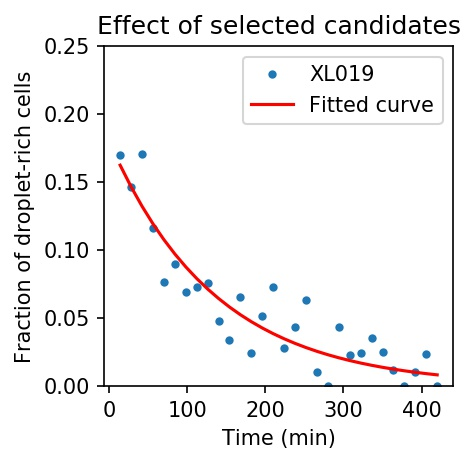

In [47]:

for i in candidates:

    P=df02[df02['drug']==i]['counts'].values
    t=(df02[df02['drug']==i]['SlowKin'].values)*420/df02['SlowKin'].max()
    popt, pcov = curve_fit(expfunc, t, P)

    P_predict = expfunc(t,popt[0],popt[1])

    plt.rcParams['figure.figsize'] = (3.0, 3.0)

    plot1 = plt.plot(t, P, '.',label=i)
    plot2 = plt.plot(t, P_predict, 'r',label='Fitted curve')

    plt.xlabel('Time (min)')
    plt.ylabel('Fraction of droplet-rich cells')
    plt.ylim([0,0.25])
    #plt.title(i)

    print(expfunc(np.array(1),popt[0],popt[1]))
    print(expfunc(np.array(30),popt[0],popt[1]))
plt.title('Effect of selected candidates')
plt.legend(loc=0) #指定legend的位置右下角

plt.show()